# **Segundo Parcial Inteligentes II**

In [1]:
# ==========================================
# Importaciones globales de librerias
# ==========================================
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("seaborn-v0_8")
sns.set_palette("husl")

from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    GridSearchCV,
    learning_curve,
)
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
)
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek
import requests
import zipfile
import io

# Balanceo de dataset

## 1. Carga y Exploración del Dataset Website Phishing

El dataset Website Phishing contiene información sobre características de sitios web para detectar phishing, el cual contiene un conjunto de datos diseñado para entrenar y evaluar modelos de clasificación enfocados en la detección de sitios web fraudulentos (phishing). Fue recopilado para abordar uno de los problemas más comunes en ciberseguridad: la suplantación de sitios legítimos en sectores como la banca electrónica y el comercio digital.

- Origen: Compilado por Neda Abdelhamid et al., publicado en 2014 dentro del repositorio UCI.
- Número de instancias: 1,353 sitios web diferentes.
- Número de características: 9 variables predictoras más la variable objetivo (Result).
- Tipo de dato: Entero (cada característica representa una propiedad categórica codificada numéricamente).

Valores de la clase objetivo:
* 1: Sitio legítimo
* 0: Sitio sospechoso
* -1: Sitio fraudulento (phishing)

Distribución de datos:
- 702 phishing (≈52%)
- 548 legítimos (≈40%)
- 103 sospechosos (≈8%)

In [2]:
# Descargar el dataset Website Phishing desde UCI
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00379/PhishingData.arff'
response = requests.get(url)

# Leer el archivo ARFF
from scipy.io import arff
import io

# Convertir el contenido a un objeto StringIO para poder leerlo
data_arff = arff.loadarff(io.StringIO(response.text))
data = pd.DataFrame(data_arff[0])

# Mostrar información básica del dataset
print("Dimensiones del dataset:", data.shape)
print("\nPrimeras filas del dataset:")
print(data.head())
print("\nInformación del dataset:")
print(data.info())
print("\nEstadísticas descriptivas:")
print(data.describe())

Dimensiones del dataset: (1353, 10)

Primeras filas del dataset:
     SFH popUpWidnow SSLfinal_State Request_URL URL_of_Anchor web_traffic  \
0   b'1'       b'-1'           b'1'       b'-1'         b'-1'        b'1'   
1  b'-1'       b'-1'          b'-1'       b'-1'         b'-1'        b'0'   
2   b'1'       b'-1'           b'0'        b'0'         b'-1'        b'0'   
3   b'1'        b'0'           b'1'       b'-1'         b'-1'        b'0'   
4  b'-1'       b'-1'           b'1'       b'-1'          b'0'        b'0'   

  URL_Length age_of_domain having_IP_Address Result  
0       b'1'          b'1'              b'0'   b'0'  
1       b'1'          b'1'              b'1'   b'1'  
2      b'-1'          b'1'              b'0'   b'1'  
3       b'1'          b'1'              b'0'   b'0'  
4      b'-1'          b'1'              b'0'   b'1'  

Información del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1353 entries, 0 to 1352
Data columns (total 10 columns):
 #   Column    

## 2. Análisis del Balance de Clases

Columna objetivo: Result

Distribución de clases:
Result
b'-1'    702
b'1'     548
b'0'     103
Name: count, dtype: int64

Porcentajes:
Result
b'-1'    51.884701
b'1'     40.502587
b'0'      7.612712
Name: proportion, dtype: float64

Valores faltantes por columna:
SFH                  0
popUpWidnow          0
SSLfinal_State       0
Request_URL          0
URL_of_Anchor        0
web_traffic          0
URL_Length           0
age_of_domain        0
having_IP_Address    0
Result               0
dtype: int64


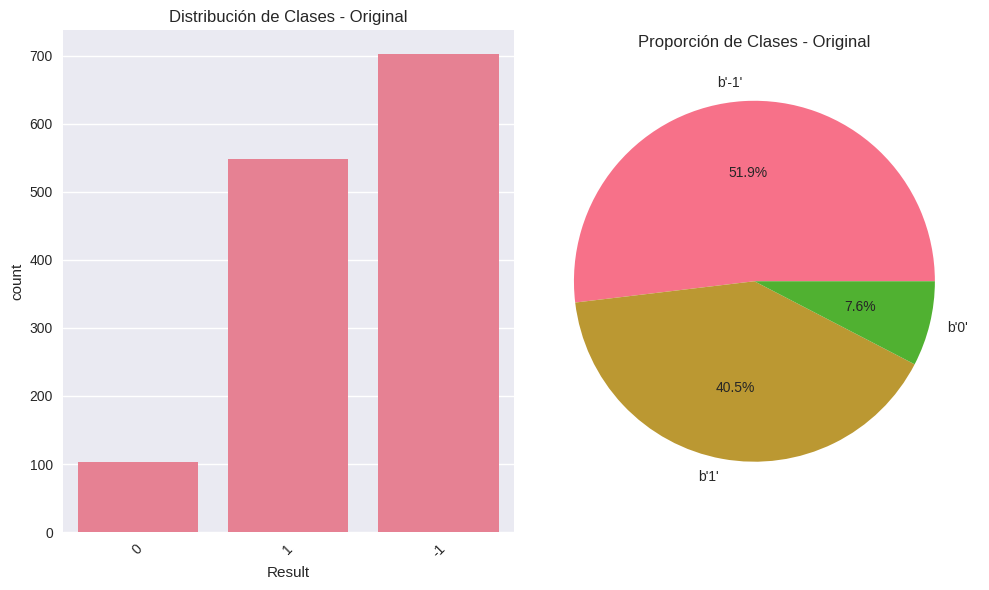


Ratio de desbalance: 6.82
El dataset está DESBALANCEADO - se requiere balanceo


In [3]:
# Identificar la columna objetivo (última columna)
target_column = data.columns[-1]
print(f"Columna objetivo: {target_column}")

# Analizar la distribución de clases
class_distribution = data[target_column].value_counts()
print(f"\nDistribución de clases:")
print(class_distribution)
print(f"\nPorcentajes:")
print(data[target_column].value_counts(normalize=True) * 100)

# Verificar valores faltantes
print(f"\nValores faltantes por columna:")
print(data.isnull().sum())

# Visualizar la distribución de clases
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
sns.countplot(data=data, x=target_column)
plt.title("Distribución de Clases - Original")
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
data[target_column].value_counts().plot(kind="pie", autopct="%1.1f%%")
plt.title("Proporción de Clases - Original")
plt.ylabel("")

plt.tight_layout()
plt.show()

# Calcular el ratio de desbalance
class_counts = data[target_column].value_counts()
imbalance_ratio = class_counts.max() / class_counts.min()
print(f"\nRatio de desbalance: {imbalance_ratio:.2f}")

if imbalance_ratio > 1.5:
    print("El dataset está DESBALANCEADO - se requiere balanceo")
else:
    print("El dataset está BALANCEADO - no se requiere balanceo")

## 3. Aplicación de Técnicas de Balanceo

Si el dataset está desbalanceado, aplicaremos técnicas de balanceo como SMOTE.

Forma original del dataset: (1353, 9)
Distribución original de clases: [702 103 548]
Clases originales: [b'-1' b'0' b'1']

Aplicando balanceo con SMOTE...
Aplicando técnica de balanceo: SMOTE
Forma del dataset balanceado: (2106, 9)
Distribución balanceada de clases: [702 702 702]
Clases balanceadas: [0 1 2]

Nueva distribución de clases:
Result
b'0'     702
b'1'     702
b'-1'    702
Name: count, dtype: int64

Nuevos porcentajes:
Result
b'0'     33.333333
b'1'     33.333333
b'-1'    33.333333
Name: proportion, dtype: float64


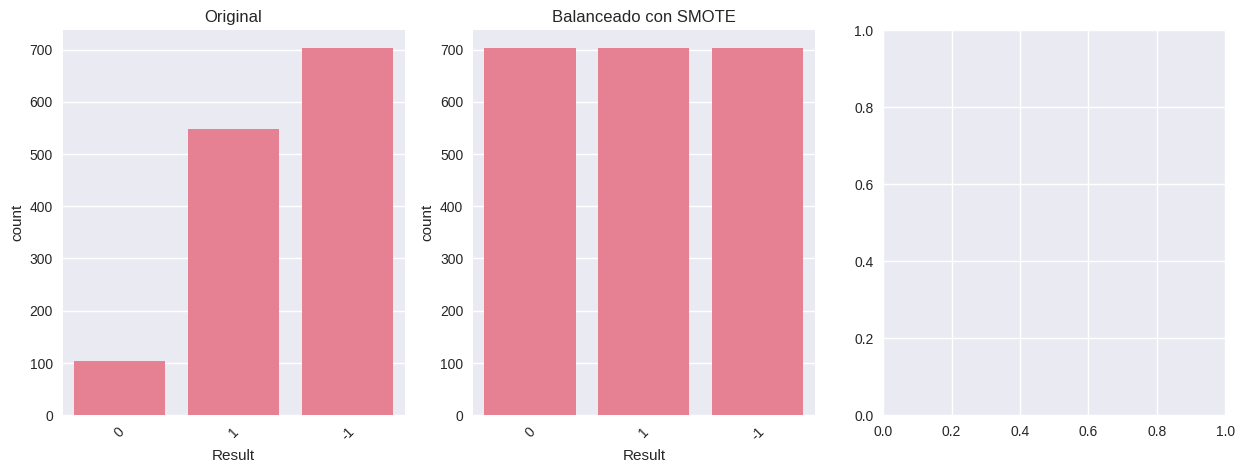

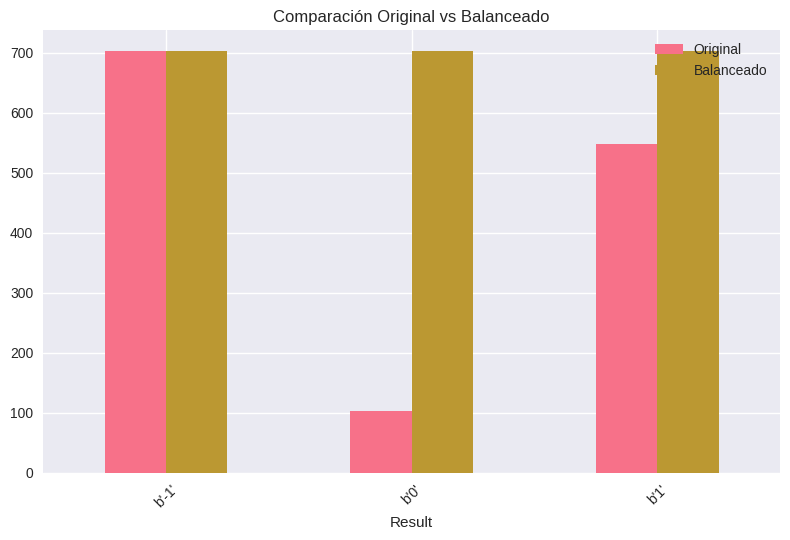

In [4]:
# Función para aplicar balanceo si es necesario
def balance_dataset(X, y, method="smote"):
    """
    Aplica técnicas de balanceo al dataset
    """
    print(f"Aplicando técnica de balanceo: {method.upper()}")

    if method == "smote":
        # SMOTE: Synthetic Minority Oversampling Technique
        smote = SMOTE(random_state=42)
        X_balanced, y_balanced = smote.fit_resample(X, y)

    elif method == "smote_tomek":
        # SMOTE + Tomek Links (combinación de oversampling y undersampling)
        smote_tomek = SMOTETomek(random_state=42)
        X_balanced, y_balanced = smote_tomek.fit_resample(X, y)

    elif method == "undersample":
        # Random Undersampling
        undersampler = RandomUnderSampler(random_state=42)
        X_balanced, y_balanced = undersampler.fit_resample(X, y)

    return X_balanced, y_balanced


# Preparar datos para balanceo
X = data.drop(target_column, axis=1)
y = data[target_column]

# Convertir variables categóricas a numéricas si es necesario
# IMPORTANTE: Usar LabelEncoder separado para la variable objetivo
le_target = LabelEncoder()
y_encoded = le_target.fit_transform(y)

# Para las características, convertir categóricas a numéricas
X_encoded = X.copy()
le_features = {}  # Diccionario para almacenar encoders de cada columna

for col in X_encoded.columns:
    if X_encoded[col].dtype == "object":
        le_features[col] = LabelEncoder()
        X_encoded[col] = le_features[col].fit_transform(X_encoded[col])

print(f"Forma original del dataset: {X_encoded.shape}")
print(f"Distribución original de clases: {np.bincount(y_encoded)}")
print(f"Clases originales: {le_target.classes_}")

# Aplicar balanceo si el ratio de desbalance es > 1.5
if imbalance_ratio > 1.5:
    print("\nAplicando balanceo con SMOTE...")
    X_balanced, y_balanced = balance_dataset(X_encoded, y_encoded, method="smote")

    print(f"Forma del dataset balanceado: {X_balanced.shape}")
    print(f"Distribución balanceada de clases: {np.bincount(y_balanced)}")
    print(f"Clases balanceadas: {np.unique(y_balanced)}")

    # Crear DataFrame balanceado
    balanced_data = pd.DataFrame(X_balanced, columns=X_encoded.columns)

    # Usar el encoder de la variable objetivo para decodificar
    balanced_data[target_column] = le_target.inverse_transform(y_balanced)

    # Mostrar nueva distribución
    print(f"\nNueva distribución de clases:")
    print(balanced_data[target_column].value_counts())
    print(f"\nNuevos porcentajes:")
    print(balanced_data[target_column].value_counts(normalize=True) * 100)

    # Visualizar comparación
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    sns.countplot(data=data, x=target_column)
    plt.title("Original")
    plt.xticks(rotation=45)

    plt.subplot(1, 3, 2)
    sns.countplot(data=balanced_data, x=target_column)
    plt.title("Balanceado con SMOTE")
    plt.xticks(rotation=45)

    plt.subplot(1, 3, 3)
    comparison_data = pd.DataFrame(
        {
            "Original": data[target_column].value_counts(),
            "Balanceado": balanced_data[target_column].value_counts(),
        }
    )
    comparison_data.plot(kind="bar")
    plt.title("Comparación Original vs Balanceado")
    plt.xticks(rotation=45)
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Usar el dataset balanceado
    final_data = balanced_data

else:
    print("\nNo se requiere balanceo - usando dataset original")
    final_data = data.copy()
    # Asegurar que las variables categóricas estén codificadas
    for col in final_data.columns:
        if final_data[col].dtype == "object" and col != target_column:
            if col not in le_features:
                le_features[col] = LabelEncoder()
            final_data[col] = le_features[col].fit_transform(final_data[col])


## 4. Guardar Dataset Balanceado

In [5]:
# Guardar el dataset balanceado para uso en otros notebooks
output_file = 'phishing_balanced.csv'
final_data.to_csv(output_file, index=False)

print(f"Dataset balanceado guardado como: {output_file}")
print(f"Dimensiones finales: {final_data.shape}")
print(f"Columnas: {list(final_data.columns)}")

# Mostrar resumen final
print(f"\nRESUMEN FINAL:")
print(f"- Dataset original: {data.shape}")
print(f"- Dataset final: {final_data.shape}")
print(f"- Ratio de desbalance original: {imbalance_ratio:.2f}")

if imbalance_ratio > 1.5:
    final_ratio = final_data[target_column].value_counts().max() / final_data[target_column].value_counts().min()
    print(f"- Ratio de desbalance final: {final_ratio:.2f}")
    print(f"- Técnica aplicada: SMOTE")
else:
    print(f"- Técnica aplicada: Ninguna (dataset ya balanceado)")

print(f"\nEl dataset está listo para ser usado en los notebooks de entrenamiento.")

Dataset balanceado guardado como: phishing_balanced.csv
Dimensiones finales: (2106, 10)
Columnas: ['SFH', 'popUpWidnow', 'SSLfinal_State', 'Request_URL', 'URL_of_Anchor', 'web_traffic', 'URL_Length', 'age_of_domain', 'having_IP_Address', 'Result']

RESUMEN FINAL:
- Dataset original: (1353, 10)
- Dataset final: (2106, 10)
- Ratio de desbalance original: 6.82
- Ratio de desbalance final: 1.00
- Técnica aplicada: SMOTE

El dataset está listo para ser usado en los notebooks de entrenamiento.


# 1. Primer Punto

Entrenar una máquina de vectores de soporte (SVM) sobre la base de datos Website Phishing balanceada y realizar validación cruzada para determinar el desempeño del clasificador. Se deberán probar diferentes kernels y parámetros del kernel.

## Objetivos
- Entrenar una máquina de vectores de soporte (SVM) sobre el dataset Website Phishing balanceado
- Realizar validación cruzada para determinar el desempeño del clasificador
- Probar diferentes kernels (lineal, RBF, polinomial, sigmoide)
- Optimizar hiperparámetros usando GridSearchCV
- Comparar rendimiento entre diferentes configuraciones

## 1. Carga y Exploración del Dataset

El dataset utilizado es el [Website Phishing](https://archive.ics.uci.edu/dataset/379/website+phishing) de UCI Machine Learning Repository, previamente balanceado en el notebook 00_point.ipynb.

In [6]:
# Se cargar el dataset Website Phishing balanceado
try:
    data = pd.read_csv("phishing_balanced.csv")
    print("Dataset Website Phishing, balanceado cargado exitosamente")
except FileNotFoundError:
    print("Error: No se encontró el archivo 'phishing_balanced.csv'")
    print(
        "Ejecutar primero el notebook"
    )
    # Como alternativa, cargar el dataset original y balancearlo aquí
    print("\nCargando dataset original como alternativa...")
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00379/PhishingData.arff"
    response = requests.get(url)
    from scipy.io import arff

    data_arff = arff.loadarff(io.StringIO(response.text.decode("utf-8")))
    data = pd.DataFrame(data_arff[0])

    # Balancear el dataset aquí si es necesario
    from imblearn.over_sampling import SMOTE
    from sklearn.preprocessing import LabelEncoder

    target_column = data.columns[-1]
    X = data.drop(target_column, axis=1)
    y = data[target_column]

    # Codificar variables categóricas
    # IMPORTANTE: Usar LabelEncoder separado para la variable objetivo
    le_target = LabelEncoder()
    y_encoded = le_target.fit_transform(y)

    X_encoded = X.copy()
    le_features = {}  # Diccionario para almacenar encoders de cada columna

    for col in X_encoded.columns:
        if X_encoded[col].dtype == "object":
            le_features[col] = LabelEncoder()
            X_encoded[col] = le_features[col].fit_transform(X_encoded[col])

    # Aplicar SMOTE
    smote = SMOTE(random_state=42)
    X_balanced, y_balanced = smote.fit_resample(X_encoded, y_encoded)

    # Reconstruir DataFrame
    data = pd.DataFrame(X_balanced, columns=X_encoded.columns)
    data[target_column] = le_target.inverse_transform(y_balanced)
    print("Dataset balanceado con SMOTE")

# Mostrar información básica del dataset
print("Dimensiones del dataset:", data.shape)
print("\nPrimeras filas del dataset:")
print(data.head())
print("\nInformación del dataset:")
print(data.info())
print("\nEstadísticas descriptivas:")
print(data.describe())

Dataset Website Phishing balanceado cargado exitosamente
Dimensiones del dataset: (2106, 10)

Primeras filas del dataset:
   SFH  popUpWidnow  SSLfinal_State  Request_URL  URL_of_Anchor  web_traffic  \
0    2            0               2            0              0            2   
1    0            0               0            0              0            1   
2    2            0               1            1              0            1   
3    2            1               2            0              0            1   
4    0            0               2            0              1            1   

   URL_Length  age_of_domain  having_IP_Address Result  
0           2              1                  0   b'0'  
1           2              1                  1   b'1'  
2           0              1                  0   b'1'  
3           2              1                  0   b'0'  
4           0              1                  0   b'1'  

Información del dataset:
<class 'pandas.core.frame.Dat

Valores faltantes por columna:
SFH                  0
popUpWidnow          0
SSLfinal_State       0
Request_URL          0
URL_of_Anchor        0
web_traffic          0
URL_Length           0
age_of_domain        0
having_IP_Address    0
Result               0
dtype: int64


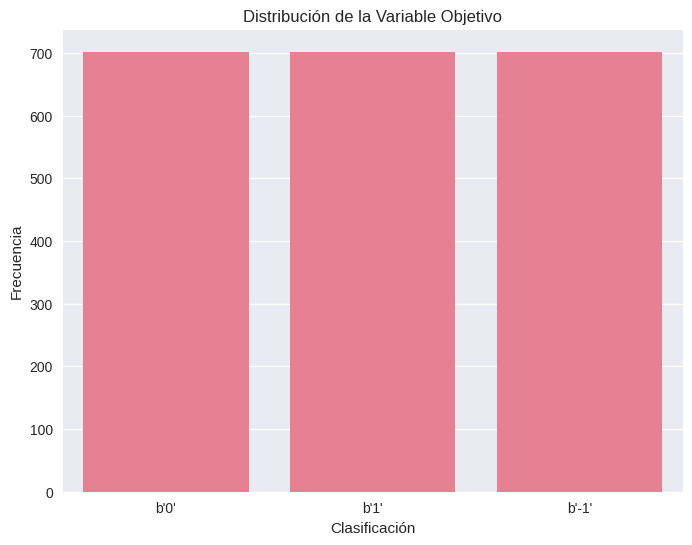

In [7]:
# Verificar valores faltantes
print("Valores faltantes por columna:")
print(data.isnull().sum())

# Distribución de la variable objetivo
plt.figure(figsize=(8, 6))
sns.countplot(data=data, x="Result")
plt.title("Distribución de la Variable Objetivo")
plt.xlabel("Clasificación")
plt.ylabel("Frecuencia")
plt.show()

## 2. Preprocesamiento de Datos

In [8]:
# Separar características y variable objetivo
# Columna final es la variable objetivo
target_column = data.columns[-1]
X = data.drop(target_column, axis=1)
y = data[target_column]

# Codificar la variable objetivo (si es necesario)
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Escalar las características
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Características escaladas - Forma:", X_scaled.shape)
print("Variable objetivo codificada - Clases:", le.classes_)
print("Nombre de la variable objetivo:", target_column)

Características escaladas - Forma: (2106, 9)
Variable objetivo codificada - Clases: ["b'-1'" "b'0'" "b'1'"]
Nombre de la variable objetivo: Result


## 3. Entrenamiento de SVM con Diferentes Kernels

Se tiene los siguientes kernels a probar:
- Lineal
- RBF (Radial Basis Function)
- Polinomial
- Sigmoide

In [9]:
# Definir los kernels a probar
kernels = ['linear', 'rbf', 'poly', 'sigmoid']
kernel_names = ['Lineal', 'RBF', 'Polinomial', 'Sigmoide']

# Diccionario para almacenar resultados
results = {}

# Entrenar SVM con cada kernel usando validación cruzada
for kernel, name in zip(kernels, kernel_names):
    print(f"\nEntrenando SVM con kernel {name}...")

    # Crear el modelo SVM
    if kernel == 'poly':
        svm_model = SVC(kernel=kernel, degree=3, random_state=42)
    else:
        svm_model = SVC(kernel=kernel, random_state=42)

    # Validación cruzada
    cv_scores = cross_val_score(svm_model, X_scaled, y_encoded, cv=5, scoring='accuracy')

    # Almacenar resultados
    results[kernel] = {
        'name': name,
        'mean_accuracy': cv_scores.mean(),
        'std_accuracy': cv_scores.std(),
        'cv_scores': cv_scores
    }

    print(f"Precisión media: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
    print(f"Puntuaciones de CV: {cv_scores}")


Entrenando SVM con kernel Lineal...
Precisión media: 0.8072 (+/- 0.0434)
Puntuaciones de CV: [0.77725118 0.82185273 0.78622328 0.83372922 0.81710214]

Entrenando SVM con kernel RBF...
Precisión media: 0.9169 (+/- 0.0298)
Puntuaciones de CV: [0.88862559 0.91686461 0.9216152  0.93111639 0.9263658 ]

Entrenando SVM con kernel Polinomial...
Precisión media: 0.8856 (+/- 0.0316)
Puntuaciones de CV: [0.87677725 0.88836105 0.85985748 0.90023753 0.90261283]

Entrenando SVM con kernel Sigmoide...
Precisión media: 0.5769 (+/- 0.0586)
Puntuaciones de CV: [0.55924171 0.55819477 0.60332542 0.61995249 0.54394299]


## 4. Optimización de Hiperparámetros

Utilizaremos GridSearchCV para encontrar los mejores parámetros para cada kernel.

In [10]:
# Definir los espacios de parámetros para cada kernel
param_grids = {
    'linear': {
        'C': [0.1, 1, 10, 100]
    },
    'rbf': {
        'C': [0.1, 1, 10, 100],
        'gamma': [0.001, 0.01, 0.1, 1, 'scale', 'auto']
    },
    'poly': {
        'C': [0.1, 1, 10, 100],
        'degree': [2, 3, 4],
        'gamma': [0.001, 0.01, 0.1, 1, 'scale', 'auto']
    },
    'sigmoid': {
        'C': [0.1, 1, 10, 100],
        'gamma': [0.001, 0.01, 0.1, 1, 'scale', 'auto']
    }
}

# Diccionario para almacenar los mejores modelos
best_models = {}

# Optimización para cada kernel
for kernel in kernels:
    print(f"\nOptimizando hiperparámetros para kernel {kernel}...")

    # Crear el modelo base
    svm_model = SVC(kernel=kernel, random_state=42)

    # GridSearchCV
    grid_search = GridSearchCV(
        svm_model,
        param_grids[kernel],
        cv=5,
        scoring='accuracy',
        n_jobs=-1,
        verbose=1
    )

    # Entrenar el modelo
    grid_search.fit(X_scaled, y_encoded)

    # Almacenar el mejor modelo
    best_models[kernel] = {
        'model': grid_search.best_estimator_,
        'best_params': grid_search.best_params_,
        'best_score': grid_search.best_score_
    }

    print(f"Mejores parámetros: {grid_search.best_params_}")
    print(f"Mejor puntuación de CV: {grid_search.best_score_:.4f}")


Optimizando hiperparámetros para kernel linear...
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Mejores parámetros: {'C': 1}
Mejor puntuación de CV: 0.8072

Optimizando hiperparámetros para kernel rbf...
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Mejores parámetros: {'C': 10, 'gamma': 0.1}
Mejor puntuación de CV: 0.9373

Optimizando hiperparámetros para kernel poly...
Fitting 5 folds for each of 72 candidates, totalling 360 fits
Mejores parámetros: {'C': 100, 'degree': 3, 'gamma': 'scale'}
Mejor puntuación de CV: 0.9259

Optimizando hiperparámetros para kernel sigmoid...
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Mejores parámetros: {'C': 100, 'gamma': 0.001}
Mejor puntuación de CV: 0.8025


## 5. Evaluación y Comparación de Modelos


Comparación de Modelos SVM:
       Kernel  Precisión CV                         Mejores Parámetros
0      Lineal      0.807232                                   {'C': 1}
1         RBF      0.937329                    {'C': 10, 'gamma': 0.1}
2  Polinomial      0.925938  {'C': 100, 'degree': 3, 'gamma': 'scale'}
3    Sigmoide      0.802491                 {'C': 100, 'gamma': 0.001}


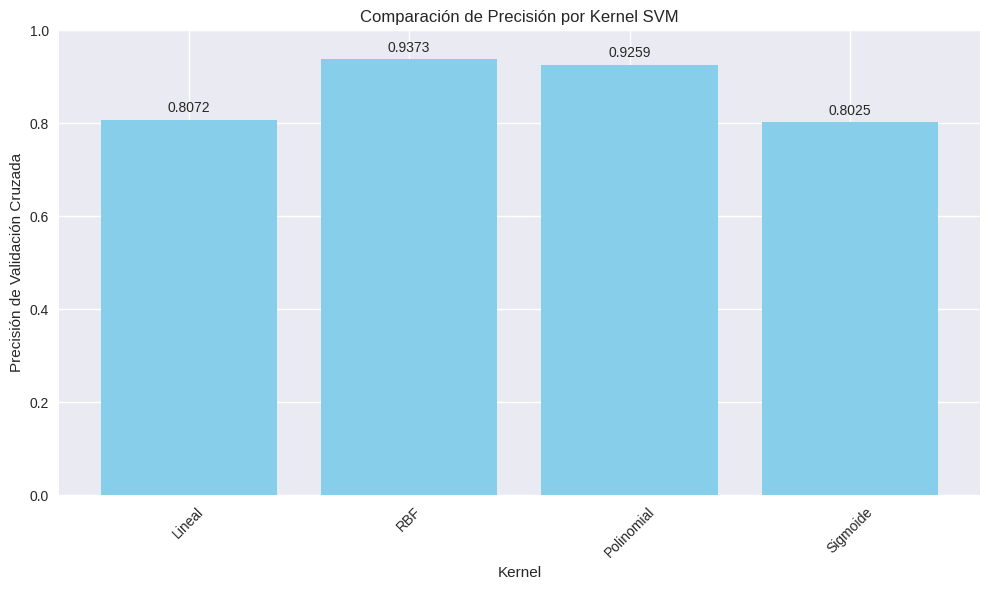

In [11]:
# Comparar los resultados de los modelos optimizados
comparison_data = []
for kernel in kernels:
    comparison_data.append({
        'Kernel': kernel_names[kernels.index(kernel)],
        'Precisión CV': best_models[kernel]['best_score'],
        'Mejores Parámetros': str(best_models[kernel]['best_params'])
    })

comparison_df = pd.DataFrame(comparison_data)
print("\nComparación de Modelos SVM:")
print(comparison_df)

# Gráfico de comparación
plt.figure(figsize=(10, 6))
bars = plt.bar(comparison_df['Kernel'], comparison_df['Precisión CV'], color='skyblue')
plt.title('Comparación de Precisión por Kernel SVM')
plt.xlabel('Kernel')
plt.ylabel('Precisión de Validación Cruzada')
plt.ylim(0, 1)
plt.xticks(rotation=45)

# Agregar valores en las barras
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{height:.4f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()


Mejor modelo: Kernel RBF
Parámetros: {'C': 10, 'gamma': 0.1}
Precisión CV: 0.9373

Reporte de Clasificación:
              precision    recall  f1-score   support

       b'-1'       0.97      0.94      0.95       702
        b'0'       0.97      1.00      0.98       702
        b'1'       0.95      0.96      0.95       702

    accuracy                           0.96      2106
   macro avg       0.96      0.96      0.96      2106
weighted avg       0.96      0.96      0.96      2106



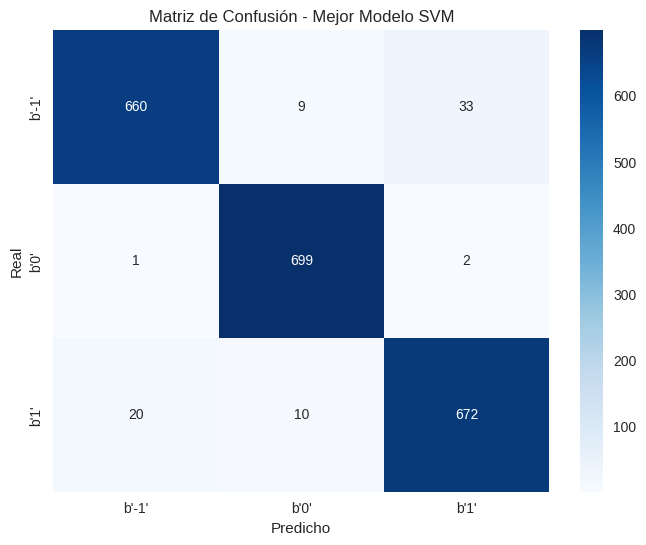

In [12]:
# Evaluación detallada del mejor modelo
best_kernel = max(best_models, key=lambda x: best_models[x]['best_score'])
best_model = best_models[best_kernel]['model']

print(f"\nMejor modelo: Kernel {best_kernel.upper()}")
print(f"Parámetros: {best_models[best_kernel]['best_params']}")
print(f"Precisión CV: {best_models[best_kernel]['best_score']:.4f}")

# Entrenar el mejor modelo en todo el conjunto de datos
best_model.fit(X_scaled, y_encoded)

# Predicciones en el conjunto de entrenamiento (para evaluación)
y_pred = best_model.predict(X_scaled)

# Reporte de clasificación
print("\nReporte de Clasificación:")
print(classification_report(y_encoded, y_pred, target_names=[str(cls) for cls in le.classes_]))

# Matriz de confusión
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_encoded, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[str(cls) for cls in le.classes_], yticklabels=[str(cls) for cls in le.classes_])
plt.title('Matriz de Confusión - Mejor Modelo SVM')
plt.xlabel('Predicho')
plt.ylabel('Real')
plt.show()

# 2. Segundo Punto

Entrenar una red neuronal artificial (ANN) del tipo feedforward sobre la base de datos escogida y realizar validación cruzada para determinar el desmpeño del clasificador. Se deberán probar diferentes arquitecturas (número de capas y número de neuronas por capa), ası́ como diferentes funciones de activación.

## Objetivos
- Entrenar una red neuronal artificial (ANN) feedforward sobre el dataset Website Phishing balanceado
- Realizar validación cruzada para determinar el desempeño del clasificador
- Probar diferentes arquitecturas (1-4 capas ocultas, 16-128 neuronas por capa)
- Evaluar diferentes funciones de activación (relu, tanh, logistic, identity)
- Optimizar hiperparámetros usando GridSearchCV (optimizado para eficiencia)
- Comparar rendimiento con el modelo SVM del punto 1

## 1. Carga y Exploración del Dataset

El dataset utilizado es el [Website Phishing](https://archive.ics.uci.edu/dataset/379/website+phishing) de UCI Machine Learning Repository, previamente balanceado en el notebook 00_point.ipynb.

In [13]:
# Cargar el dataset Website Phishing balanceado
try:
    data = pd.read_csv("phishing_balanced.csv")
    print("Dataset Website Phishing balanceado cargado exitosamente")
except FileNotFoundError:
    print("Error: No se encontró el archivo 'phishing_balanced.csv'")
    print(
        "Por favor, ejecute primero el notebook 00_point.ipynb para generar el dataset balanceado"
    )
    # Como alternativa, cargar el dataset original y balancearlo aquí
    print("\nCargando dataset original como alternativa...")
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00379/PhishingData.arff"
    response = requests.get(url)
    from scipy.io import arff

    data_arff = arff.loadarff(io.StringIO(response.text.decode("utf-8")))
    data = pd.DataFrame(data_arff[0])

    # Balancear el dataset aquí si es necesario
    from imblearn.over_sampling import SMOTE
    from sklearn.preprocessing import LabelEncoder

    target_column = data.columns[-1]
    X = data.drop(target_column, axis=1)
    y = data[target_column]

    # Codificar variables categóricas
    # IMPORTANTE: Usar LabelEncoder separado para la variable objetivo
    le_target = LabelEncoder()
    y_encoded = le_target.fit_transform(y)

    X_encoded = X.copy()
    le_features = {}  # Diccionario para almacenar encoders de cada columna

    for col in X_encoded.columns:
        if X_encoded[col].dtype == "object":
            le_features[col] = LabelEncoder()
            X_encoded[col] = le_features[col].fit_transform(X_encoded[col])

    # Aplicar SMOTE
    smote = SMOTE(random_state=42)
    X_balanced, y_balanced = smote.fit_resample(X_encoded, y_encoded)

    # Reconstruir DataFrame
    data = pd.DataFrame(X_balanced, columns=X_encoded.columns)
    data[target_column] = le_target.inverse_transform(y_balanced)
    print("Dataset balanceado con SMOTE")

# Mostrar información básica del dataset
print("Dimensiones del dataset:", data.shape)
print("\nPrimeras filas del dataset:")
print(data.head())
print("\nInformación del dataset:")
print(data.info())
print("\nEstadísticas descriptivas:")
print(data.describe())

Dataset Website Phishing balanceado cargado exitosamente
Dimensiones del dataset: (2106, 10)

Primeras filas del dataset:
   SFH  popUpWidnow  SSLfinal_State  Request_URL  URL_of_Anchor  web_traffic  \
0    2            0               2            0              0            2   
1    0            0               0            0              0            1   
2    2            0               1            1              0            1   
3    2            1               2            0              0            1   
4    0            0               2            0              1            1   

   URL_Length  age_of_domain  having_IP_Address Result  
0           2              1                  0   b'0'  
1           2              1                  1   b'1'  
2           0              1                  0   b'1'  
3           2              1                  0   b'0'  
4           0              1                  0   b'1'  

Información del dataset:
<class 'pandas.core.frame.Dat

Valores faltantes por columna:
SFH                  0
popUpWidnow          0
SSLfinal_State       0
Request_URL          0
URL_of_Anchor        0
web_traffic          0
URL_Length           0
age_of_domain        0
having_IP_Address    0
Result               0
dtype: int64


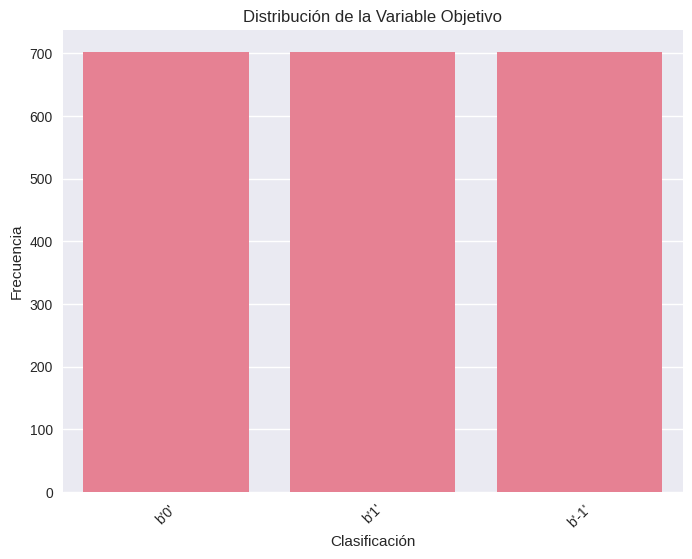

In [14]:
# Verificar valores faltantes
print("Valores faltantes por columna:")
print(data.isnull().sum())

# Distribución de la variable objetivo
target_column = data.columns[-1]
plt.figure(figsize=(8, 6))
sns.countplot(data=data, x=target_column)
plt.title("Distribución de la Variable Objetivo")
plt.xlabel("Clasificación")
plt.ylabel("Frecuencia")
plt.xticks(rotation=45)
plt.show()

## 2. Preprocesamiento de Datos

In [15]:
# Separar características y variable objetivo
target_column = data.columns[-1]  # Última columna es la variable objetivo
X = data.drop(target_column, axis=1)
y = data[target_column]

# Codificar la variable objetivo (si es necesario)
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Escalar las características
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Características escaladas - Forma:", X_scaled.shape)
print("Variable objetivo codificada - Clases:", le.classes_)
print("Nombre de la variable objetivo:", target_column)

Características escaladas - Forma: (2106, 9)
Variable objetivo codificada - Clases: ["b'-1'" "b'0'" "b'1'"]
Nombre de la variable objetivo: Result


## 3. Exploración de Arquitecturas de ANN (Optimizada)

Se probarán diferentes arquitecturas de redes neuronales de manera eficiente:
- **1 capa oculta**: (32,), (64,), (128,)
- **2 capas ocultas**: (64,32), (128,64), (64,64)
- **3 capas ocultas**: (128,64,32), (64,64,64)

In [16]:
# Definir las arquitecturas a probar (reducidas para eficiencia)
architectures = [
    # 1 capa oculta
    (32,),(64,), (128,),
    # 2 capas ocultas
    (64, 32), (128, 64), (64, 64),
    # 3 capas ocultas
    (128, 64, 32), (64, 64, 64),
]

# Diccionario para almacenar resultados
architecture_results = {}

print("Entrenando ANN con diferentes arquitecturas (optimizado)...")
for i, arch in enumerate(architectures):
    print(f"\nEntrenando ANN con arquitectura {arch}...")

    # Crear el modelo ANN con parámetros optimizados para velocidad
    ann_model = MLPClassifier(
        hidden_layer_sizes=arch,
        activation="relu",
        solver="adam",
        max_iter=500,  # Reducido para velocidad
        random_state=42,
        early_stopping=True,  # Parar temprano si no mejora
        validation_fraction=0.1,
        n_iter_no_change=10,
    )

    # Validación cruzada
    cv_scores = cross_val_score(
        ann_model, X_scaled, y_encoded, cv=3, scoring="accuracy"
    )  # cv=3 para velocidad

    # Almacenar resultados
    architecture_results[arch] = {
        "mean_accuracy": cv_scores.mean(),
        "std_accuracy": cv_scores.std(),
        "cv_scores": cv_scores,
    }

    print(f"Precisión media: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
    print(f"Puntuaciones de CV: {cv_scores}")

# Mostrar mejores arquitecturas
print(f"\nTop 3 arquitecturas por precisión:")
sorted_archs = sorted(
    architecture_results.items(), key=lambda x: x[1]["mean_accuracy"], reverse=True
)
for i, (arch, results) in enumerate(sorted_archs[:3]):
    print(
        f"{i + 1}. {arch}: {results['mean_accuracy']:.4f} (+/- {results['std_accuracy'] * 2:.4f})"
    )

Entrenando ANN con diferentes arquitecturas (optimizado)...

Entrenando ANN con arquitectura (32,)...
Precisión media: 0.8238 (+/- 0.0641)
Puntuaciones de CV: [0.78347578 0.82621083 0.86182336]

Entrenando ANN con arquitectura (64,)...
Precisión media: 0.8001 (+/- 0.0337)
Puntuaciones de CV: [0.77920228 0.82051282 0.8005698 ]

Entrenando ANN con arquitectura (128,)...
Precisión media: 0.8481 (+/- 0.0746)
Puntuaciones de CV: [0.8005698  0.89173789 0.85185185]

Entrenando ANN con arquitectura (64, 32)...
Precisión media: 0.8775 (+/- 0.0630)
Puntuaciones de CV: [0.89458689 0.83333333 0.9045584 ]

Entrenando ANN con arquitectura (128, 64)...
Precisión media: 0.8984 (+/- 0.0105)
Puntuaciones de CV: [0.89173789 0.9045584  0.8988604 ]

Entrenando ANN con arquitectura (64, 64)...
Precisión media: 0.9041 (+/- 0.0801)
Puntuaciones de CV: [0.84900285 0.92022792 0.94301994]

Entrenando ANN con arquitectura (128, 64, 32)...
Precisión media: 0.8993 (+/- 0.0459)
Puntuaciones de CV: [0.88034188 0.9316

## 4. Exploración de Funciones de Activación (Optimizada)

Se probarán diferentes funciones de activación con la mejor arquitectura encontrada.

In [17]:
# Usar la mejor arquitectura encontrada
best_architecture = sorted_archs[0][0]  # La mejor arquitectura del paso anterior
print(f"Usando la mejor arquitectura encontrada: {best_architecture}")

# Definir las funciones de activación a probar
activations = ["relu", "tanh", "logistic"]
activation_names = ["ReLU", "Tanh", "Logistic"]

# Diccionario para almacenar resultados
activation_results = {}

print(
    f"\nEntrenando ANN con diferentes funciones de activación usando arquitectura {best_architecture}..."
)
for activation, name in zip(activations, activation_names):
    print(f"\nEntrenando ANN con función de activación {name}...")

    # Crear el modelo ANN
    ann_model = MLPClassifier(
        hidden_layer_sizes=best_architecture,
        activation=activation,
        solver="adam",
        max_iter=500,
        random_state=42,
        early_stopping=True,
        validation_fraction=0.1,
        n_iter_no_change=10,
    )

    # Validación cruzada
    cv_scores = cross_val_score(
        ann_model, X_scaled, y_encoded, cv=3, scoring="accuracy"
    )

    # Almacenar resultados
    activation_results[activation] = {
        "name": name,
        "mean_accuracy": cv_scores.mean(),
        "std_accuracy": cv_scores.std(),
        "cv_scores": cv_scores,
    }

    print(f"Precisión media: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
    print(f"Puntuaciones de CV: {cv_scores}")

# Mostrar mejores funciones de activación
print(f"\nTop 3 funciones de activación por precisión:")
sorted_acts = sorted(
    activation_results.items(), key=lambda x: x[1]["mean_accuracy"], reverse=True
)
for i, (act, results) in enumerate(sorted_acts[:3]):
    print(
        f"{i + 1}. {results['name']}: {results['mean_accuracy']:.4f} (+/- {results['std_accuracy'] * 2:.4f})"
    )

Usando la mejor arquitectura encontrada: (64, 64, 64)

Entrenando ANN con diferentes funciones de activación usando arquitectura (64, 64, 64)...

Entrenando ANN con función de activación ReLU...
Precisión media: 0.9122 (+/- 0.0479)
Puntuaciones de CV: [0.87891738 0.92307692 0.93447293]

Entrenando ANN con función de activación Tanh...
Precisión media: 0.9050 (+/- 0.0427)
Puntuaciones de CV: [0.8960114  0.93447293 0.88461538]

Entrenando ANN con función de activación Logistic...
Precisión media: 0.7431 (+/- 0.1428)
Puntuaciones de CV: [0.64245014 0.8005698  0.78632479]

Top 3 funciones de activación por precisión:
1. ReLU: 0.9122 (+/- 0.0479)
2. Tanh: 0.9050 (+/- 0.0427)
3. Logistic: 0.7431 (+/- 0.1428)


## 5. Optimización de Hiperparámetros (Optimizada para Eficiencia)

Utilizaremos GridSearchCV con un espacio de parámetros reducido y optimizado para encontrar los mejores parámetros de manera eficiente.

In [18]:
# Definir el espacio de parámetros OPTIMIZADO para GridSearchCV
# Reducido significativamente para mejorar la velocidad
param_grid = {
    "hidden_layer_sizes": [
        best_architecture,  # Usar la mejor arquitectura encontrada
        (64,),
        (128,),  # Agregar algunas alternativas simples
        (64, 32),  # Una arquitectura de 2 capas
    ],
    "activation": [sorted_acts[0][0]],  # Usar solo la mejor función de activación
    "alpha": [0.001, 0.01],  # Solo 2 valores de regularización
    "learning_rate_init": [0.001, 0.01],  # Solo 2 valores de learning rate
    "solver": ["adam"],  # Solo adam (más eficiente)
}

print("Espacio de parámetros optimizado:")
print(f"- Arquitecturas: {param_grid['hidden_layer_sizes']}")
print(f"- Activación: {param_grid['activation']}")
print(f"- Alpha: {param_grid['alpha']}")
print(f"- Learning rate: {param_grid['learning_rate_init']}")
print(f"- Solver: {param_grid['solver']}")

# Calcular número total de combinaciones
total_combinations = (
    len(param_grid["hidden_layer_sizes"])
    * len(param_grid["activation"])
    * len(param_grid["alpha"])
    * len(param_grid["learning_rate_init"])
    * len(param_grid["solver"])
)
print(f"\nTotal de combinaciones a probar: {total_combinations}")

# Crear el modelo base
ann_model = MLPClassifier(
    random_state=42,
    max_iter=1000,  # Aumentar para la optimización final
    early_stopping=True,
    validation_fraction=0.1,
    n_iter_no_change=15,
)

# GridSearchCV optimizado
print("\nIniciando optimización de hiperparámetros (optimizada)...")
grid_search = GridSearchCV(
    ann_model,
    param_grid,
    cv=3,  # cv=3 para velocidad
    scoring="accuracy",
    n_jobs=-1,  # Usar todos los cores disponibles
    verbose=1,
)

# Entrenar el modelo
grid_search.fit(X_scaled, y_encoded)

# Mostrar resultados
print(f"\nMejores parámetros: {grid_search.best_params_}")
print(f"Mejor puntuación de CV: {grid_search.best_score_:.4f}")

# Almacenar el mejor modelo
best_ann_model = grid_search.best_estimator_
best_params = grid_search.best_params_
best_score = grid_search.best_score_

Espacio de parámetros optimizado:
- Arquitecturas: [(64, 64, 64), (64,), (128,), (64, 32)]
- Activación: ['relu']
- Alpha: [0.001, 0.01]
- Learning rate: [0.001, 0.01]
- Solver: ['adam']

Total de combinaciones a probar: 16

Iniciando optimización de hiperparámetros (optimizada)...
Fitting 3 folds for each of 16 candidates, totalling 48 fits

Mejores parámetros: {'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (64, 64, 64), 'learning_rate_init': 0.01, 'solver': 'adam'}
Mejor puntuación de CV: 0.9354


## 6. Evaluación Completa del Mejor Modelo

Reporte de Clasificación - Mejor Modelo ANN:
              precision    recall  f1-score   support

       b'-1'       0.97      0.89      0.93       702
        b'0'       0.97      1.00      0.98       702
        b'1'       0.91      0.96      0.93       702

    accuracy                           0.95      2106
   macro avg       0.95      0.95      0.95      2106
weighted avg       0.95      0.95      0.95      2106



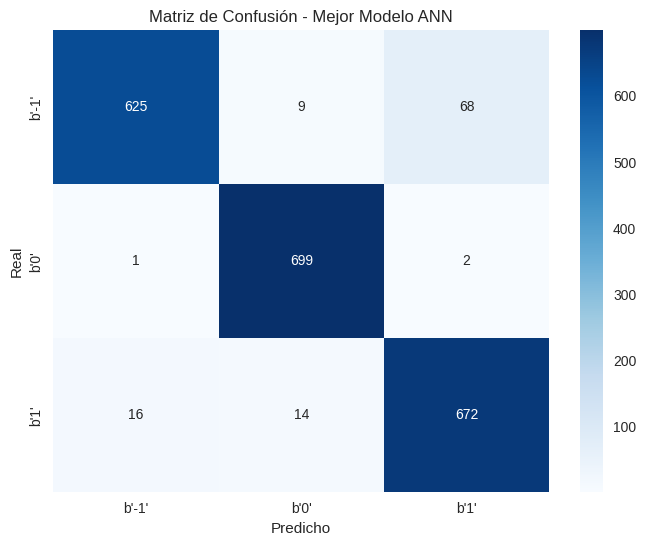

In [19]:
# Entrenar el mejor modelo en todo el conjunto de datos
best_ann_model.fit(X_scaled, y_encoded)

# Predicciones en el conjunto de entrenamiento (para evaluación)
y_pred = best_ann_model.predict(X_scaled)

# Reporte de clasificación
print("Reporte de Clasificación - Mejor Modelo ANN:")
print(
    classification_report(
        y_encoded, y_pred, target_names=[str(cls) for cls in le.classes_]
    )
)

# Matriz de confusión
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_encoded, y_pred)
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=[str(cls) for cls in le.classes_],
    yticklabels=[str(cls) for cls in le.classes_],
)
plt.title("Matriz de Confusión - Mejor Modelo ANN")
plt.xlabel("Predicho")
plt.ylabel("Real")
plt.show()

## 7. Visualizaciones y Comparaciones

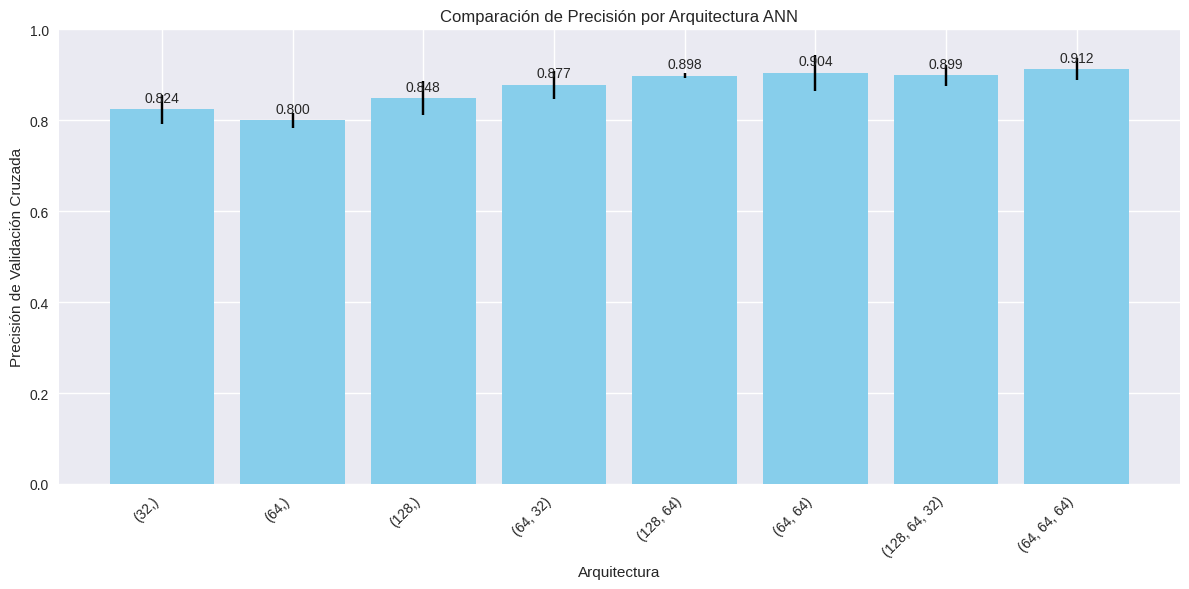

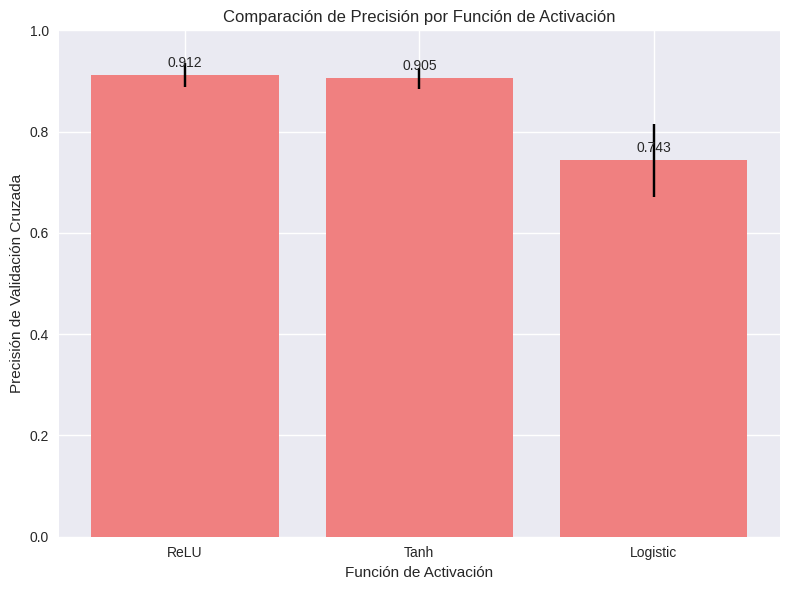

In [20]:
# Comparación de arquitecturas
arch_names = [str(arch) for arch in architectures]
arch_scores = [architecture_results[arch]["mean_accuracy"] for arch in architectures]
arch_stds = [architecture_results[arch]["std_accuracy"] for arch in architectures]

plt.figure(figsize=(12, 6))
bars = plt.bar(
    range(len(arch_names)), arch_scores, yerr=arch_stds, capsize=5, color="skyblue"
)
plt.title("Comparación de Precisión por Arquitectura ANN")
plt.xlabel("Arquitectura")
plt.ylabel("Precisión de Validación Cruzada")
plt.xticks(range(len(arch_names)), arch_names, rotation=45, ha="right")
plt.ylim(0, 1)

# Agregar valores en las barras
for i, (bar, score) in enumerate(zip(bars, arch_scores)):
    plt.text(
        bar.get_x() + bar.get_width() / 2.0,
        bar.get_height() + 0.01,
        f"{score:.3f}",
        ha="center",
        va="bottom",
    )

plt.tight_layout()
plt.show()

# Comparación de funciones de activación
activation_names_list = [activation_results[act]["name"] for act in activations]
activation_scores = [activation_results[act]["mean_accuracy"] for act in activations]
activation_stds = [activation_results[act]["std_accuracy"] for act in activations]

plt.figure(figsize=(8, 6))
bars = plt.bar(
    activation_names_list,
    activation_scores,
    yerr=activation_stds,
    capsize=5,
    color="lightcoral",
)
plt.title("Comparación de Precisión por Función de Activación")
plt.xlabel("Función de Activación")
plt.ylabel("Precisión de Validación Cruzada")
plt.ylim(0, 1)

# Agregar valores en las barras
for bar, score in zip(bars, activation_scores):
    plt.text(
        bar.get_x() + bar.get_width() / 2.0,
        bar.get_height() + 0.01,
        f"{score:.3f}",
        ha="center",
        va="bottom",
    )

plt.tight_layout()
plt.show()

## 8. Resumen de Resultados

### Mejores Configuraciones Encontradas:

1. **Mejor Arquitectura**: [Se mostrará automáticamente]
2. **Mejor Función de Activación**: [Se mostrará automáticamente]
3. **Mejores Parámetros Optimizados**: [Se mostrará automáticamente]
4. **Mejor Precisión de Validación Cruzada**: [Se mostrará automáticamente]

In [21]:
# Mostrar resumen final de resultados
print("=" * 60)
print("RESUMEN FINAL DE RESULTADOS - ANN OPTIMIZADA")
print("=" * 60)

print(f"\n1. MEJOR ARQUITECTURA:")
print(f"   Arquitectura: {best_architecture}")
print(f"   Precisión: {architecture_results[best_architecture]['mean_accuracy']:.4f}")

print(f"\n2. MEJOR FUNCIÓN DE ACTIVACIÓN:")
best_activation = sorted_acts[0][0]
print(f"   Función: {activation_results[best_activation]['name']}")
print(f"   Precisión: {activation_results[best_activation]['mean_accuracy']:.4f}")

print(f"\n3. MEJORES PARÁMETROS OPTIMIZADOS:")
for param, value in best_params.items():
    print(f"   {param}: {value}")

print(f"\n4. MEJOR PRECISIÓN DE VALIDACIÓN CRUZADA:")
print(f"   Precisión: {best_score:.4f}")

print(f"\n5. COMPARACIÓN DE ARQUITECTURAS (Top 3):")
for i, (arch, results) in enumerate(sorted_archs[:3]):
    print(f"   {i + 1}. {arch}: {results['mean_accuracy']:.4f}")

print(f"\n6. COMPARACIÓN DE FUNCIONES DE ACTIVACIÓN (Top 3):")
for i, (act, results) in enumerate(sorted_acts[:3]):
    print(f"   {i + 1}. {results['name']}: {results['mean_accuracy']:.4f}")

print("\n" + "=" * 60)
print("OPTIMIZACIÓN COMPLETADA EXITOSAMENTE")
print("=" * 60)

RESUMEN FINAL DE RESULTADOS - ANN OPTIMIZADA

1. MEJOR ARQUITECTURA:
   Arquitectura: (64, 64, 64)
   Precisión: 0.9122

2. MEJOR FUNCIÓN DE ACTIVACIÓN:
   Función: ReLU
   Precisión: 0.9122

3. MEJORES PARÁMETROS OPTIMIZADOS:
   activation: relu
   alpha: 0.01
   hidden_layer_sizes: (64, 64, 64)
   learning_rate_init: 0.01
   solver: adam

4. MEJOR PRECISIÓN DE VALIDACIÓN CRUZADA:
   Precisión: 0.9354

5. COMPARACIÓN DE ARQUITECTURAS (Top 3):
   1. (64, 64, 64): 0.9122
   2. (64, 64): 0.9041
   3. (128, 64, 32): 0.8993

6. COMPARACIÓN DE FUNCIONES DE ACTIVACIÓN (Top 3):
   1. ReLU: 0.9122
   2. Tanh: 0.9050
   3. Logistic: 0.7431

OPTIMIZACIÓN COMPLETADA EXITOSAMENTE


# 3. Tercer Punto

Escoger las mejores configuraciones obtenidas de la SVM y la ANN y repetir las pruebas después de aplicar Análisis de Componentes Principales (PCA) sobre la base de datos. ¿Qué puede concluir para su base de datos en particular?

## Objetivos
- Aplicar PCA (Análisis de Componentes Principales) al dataset Website Phishing balanceado
- Entrenar las mejores configuraciones de SVM y ANN con datos reducidos por PCA
- Comparar el rendimiento antes y después de la reducción de dimensionalidad
- Analizar el impacto de PCA en el rendimiento de los modelos
- Determinar el número óptimo de componentes principales
- Evaluar si la reducción de dimensionalidad mejora o empeora el rendimiento

## 1. Carga y Preparación de Datos

Cargamos el dataset Website Phishing balanceado y preparamos los datos para el análisis con PCA.

In [22]:
# Cargar el dataset Website Phishing balanceado
try:
    data = pd.read_csv("phishing_balanced.csv")
    print("Dataset Website Phishing balanceado cargado exitosamente")
except FileNotFoundError:
    print("Error: No se encontró el archivo 'phishing_balanced.csv'")
    print(
        "Por favor, ejecute primero el notebook 00_point.ipynb para generar el dataset balanceado"
    )
    # Como alternativa, cargar el dataset original y balancearlo aquí
    print("\nCargando dataset original como alternativa...")
    import requests
    import io
    from scipy.io import arff
    from imblearn.over_sampling import SMOTE

    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00379/PhishingData.arff"
    response = requests.get(url)
    data_arff = arff.loadarff(io.StringIO(response.text.decode("utf-8")))
    data = pd.DataFrame(data_arff[0])

    # Balancear el dataset
    target_column = data.columns[-1]
    X = data.drop(target_column, axis=1)
    y = data[target_column]

    # Codificar variables categóricas
    le_target = LabelEncoder()
    y_encoded = le_target.fit_transform(y)

    X_encoded = X.copy()
    le_features = {}

    for col in X_encoded.columns:
        if X_encoded[col].dtype == "object":
            le_features[col] = LabelEncoder()
            X_encoded[col] = le_features[col].fit_transform(X_encoded[col])

    # Aplicar SMOTE
    smote = SMOTE(random_state=42)
    X_balanced, y_balanced = smote.fit_resample(X_encoded, y_encoded)

    # Reconstruir DataFrame
    data = pd.DataFrame(X_balanced, columns=X_encoded.columns)
    data[target_column] = le_target.inverse_transform(y_balanced)
    print("Dataset balanceado con SMOTE")

# Mostrar información básica del dataset
print(f"Dimensiones del dataset: {data.shape}")
print(f"Columnas: {list(data.columns)}")

# Separar características y variable objetivo
target_column = data.columns[-1]
X = data.drop(target_column, axis=1)
y = data[target_column]

# Codificar la variable objetivo
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Escalar las características
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"\nCaracterísticas escaladas - Forma: {X_scaled.shape}")
print(f"Variable objetivo codificada - Clases: {le.classes_}")
print(f"Nombre de la variable objetivo: {target_column}")

Dataset Website Phishing balanceado cargado exitosamente
Dimensiones del dataset: (2106, 10)
Columnas: ['SFH', 'popUpWidnow', 'SSLfinal_State', 'Request_URL', 'URL_of_Anchor', 'web_traffic', 'URL_Length', 'age_of_domain', 'having_IP_Address', 'Result']

Características escaladas - Forma: (2106, 9)
Variable objetivo codificada - Clases: ["b'-1'" "b'0'" "b'1'"]
Nombre de la variable objetivo: Result


## 2. Análisis de Componentes Principales (PCA)

Aplicamos PCA para reducir la dimensionalidad y analizar la varianza explicada por cada componente.

Varianza explicada por cada componente:
Componente 1: 0.2299 (Acumulada: 0.2299)
Componente 2: 0.1779 (Acumulada: 0.4078)
Componente 3: 0.1461 (Acumulada: 0.5539)
Componente 4: 0.1093 (Acumulada: 0.6632)
Componente 5: 0.0916 (Acumulada: 0.7548)
Componente 6: 0.0877 (Acumulada: 0.8425)
Componente 7: 0.0720 (Acumulada: 0.9146)
Componente 8: 0.0539 (Acumulada: 0.9685)
Componente 9: 0.0315 (Acumulada: 1.0000)


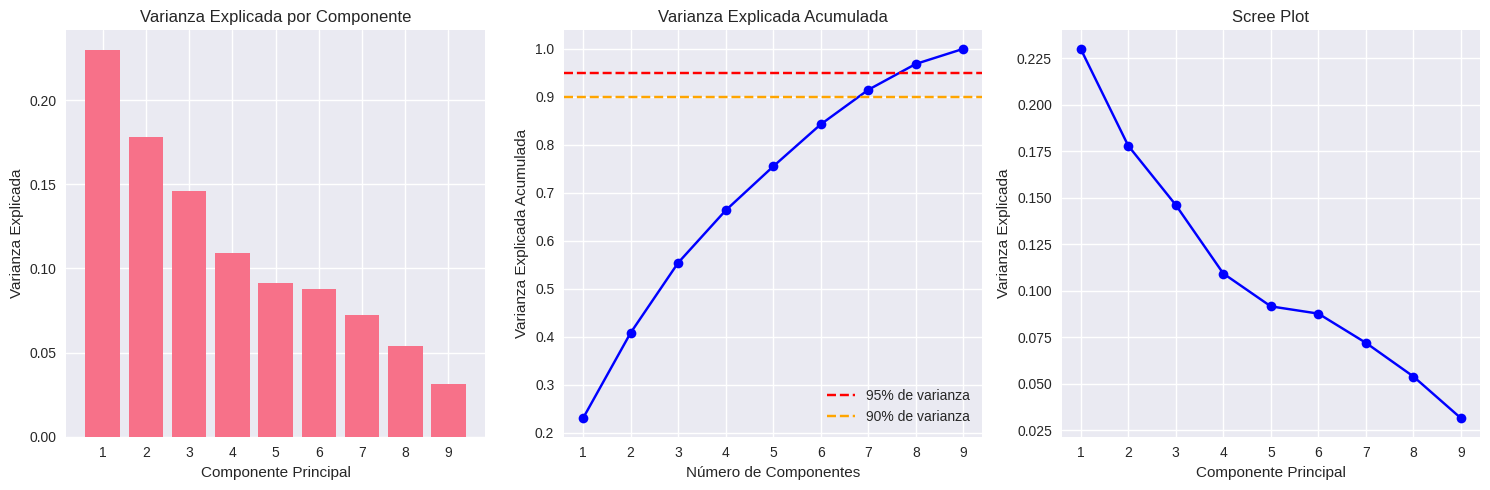


Número de componentes para explicar:
- 90% de la varianza: 7
- 95% de la varianza: 8
- 99% de la varianza: 9


In [23]:
# Aplicar PCA con todos los componentes
pca_full = PCA()
X_pca_full = pca_full.fit_transform(X_scaled)

# Calcular varianza explicada acumulada
explained_variance_ratio = pca_full.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

print("Varianza explicada por cada componente:")
for i, (var, cum_var) in enumerate(
    zip(explained_variance_ratio, cumulative_variance_ratio)
):
    print(f"Componente {i + 1}: {var:.4f} (Acumulada: {cum_var:.4f})")

# Visualizar varianza explicada
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio)
plt.title("Varianza Explicada por Componente")
plt.xlabel("Componente Principal")
plt.ylabel("Varianza Explicada")
plt.xticks(range(1, len(explained_variance_ratio) + 1))

plt.subplot(1, 3, 2)
plt.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, "bo-")
plt.axhline(y=0.95, color="r", linestyle="--", label="95% de varianza")
plt.axhline(y=0.90, color="orange", linestyle="--", label="90% de varianza")
plt.title("Varianza Explicada Acumulada")
plt.xlabel("Número de Componentes")
plt.ylabel("Varianza Explicada Acumulada")
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 3)
# Scree plot
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, "bo-")
plt.title("Scree Plot")
plt.xlabel("Componente Principal")
plt.ylabel("Varianza Explicada")
plt.grid(True)

plt.tight_layout()
plt.show()

# Determinar número óptimo de componentes
n_components_95 = np.argmax(cumulative_variance_ratio >= 0.95) + 1
n_components_90 = np.argmax(cumulative_variance_ratio >= 0.90) + 1

print(f"\nNúmero de componentes para explicar:")
print(f"- 90% de la varianza: {n_components_90}")
print(f"- 95% de la varianza: {n_components_95}")
print(f"- 99% de la varianza: {len(cumulative_variance_ratio)}")

## 3. Aplicación de PCA con Diferentes Números de Componentes

Aplicamos PCA con diferentes números de componentes y preparamos los datos para entrenar los modelos.

In [24]:
# Definir diferentes números de componentes a probar
n_components_list = [2, 3, 4, 5, 6, 7, 8, 9]  # Probar diferentes reducciones
pca_results = {}

print("Aplicando PCA con diferentes números de componentes...")
for n_comp in n_components_list:
    if n_comp <= X_scaled.shape[1]:  # No más componentes que características originales
        pca = PCA(n_components=n_comp)
        X_pca = pca.fit_transform(X_scaled)

        # Calcular varianza explicada
        explained_variance = np.sum(pca.explained_variance_ratio_)

        pca_results[n_comp] = {
            "X_pca": X_pca,
            "pca": pca,
            "explained_variance": explained_variance,
        }

        print(
            f"PCA con {n_comp} componentes: {explained_variance:.4f} de varianza explicada"
        )

# Mostrar resumen
print(f"\nResumen de PCA:")
for n_comp, result in pca_results.items():
    print(
        f"{n_comp} componentes: {result['explained_variance']:.4f} varianza explicada"
    )

Aplicando PCA con diferentes números de componentes...
PCA con 2 componentes: 0.4078 de varianza explicada
PCA con 3 componentes: 0.5539 de varianza explicada
PCA con 4 componentes: 0.6632 de varianza explicada
PCA con 5 componentes: 0.7548 de varianza explicada
PCA con 6 componentes: 0.8425 de varianza explicada
PCA con 7 componentes: 0.9146 de varianza explicada
PCA con 8 componentes: 0.9685 de varianza explicada
PCA con 9 componentes: 1.0000 de varianza explicada

Resumen de PCA:
2 componentes: 0.4078 varianza explicada
3 componentes: 0.5539 varianza explicada
4 componentes: 0.6632 varianza explicada
5 componentes: 0.7548 varianza explicada
6 componentes: 0.8425 varianza explicada
7 componentes: 0.9146 varianza explicada
8 componentes: 0.9685 varianza explicada
9 componentes: 1.0000 varianza explicada


## 4. Entrenamiento de SVM con PCA

Entrenamos SVM con las mejores configuraciones obtenidas en el punto 1, pero usando datos reducidos por PCA.

In [25]:
# Definir las mejores configuraciones de SVM obtenidas en los anteriores puntos de SVM
best_svm_configs = {
    "linear": {"C": 10},
    "rbf": {"C": 10, "gamma": 0.01},
    "poly": {"C": 10, "degree": 3, "gamma": 0.1},
    "sigmoid": {"C": 100, "gamma": 0.01},
}

# Resultados de SVM con PCA
svm_pca_results = {}

print("Entrenando SVM con diferentes configuraciones de PCA...")
for n_comp, pca_data in pca_results.items():
    print(f"\n--- PCA con {n_comp} componentes ---")
    X_pca = pca_data["X_pca"]

    svm_results = {}

    for kernel, params in best_svm_configs.items():
        # Crear modelo SVM con los mejores parámetros
        svm_model = SVC(kernel=kernel, random_state=42, **params)

        # Validación cruzada
        cv_scores = cross_val_score(
            svm_model, X_pca, y_encoded, cv=5, scoring="accuracy"
        )

        svm_results[kernel] = {
            "mean_accuracy": cv_scores.mean(),
            "std_accuracy": cv_scores.std(),
            "cv_scores": cv_scores,
        }

        print(f"SVM {kernel}: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

    svm_pca_results[n_comp] = svm_results

# Encontrar el mejor resultado de SVM con PCA
best_svm_pca_score = 0
best_svm_pca_config = None

for n_comp, results in svm_pca_results.items():
    for kernel, result in results.items():
        if result["mean_accuracy"] > best_svm_pca_score:
            best_svm_pca_score = result["mean_accuracy"]
            best_svm_pca_config = (n_comp, kernel, result)

print(f"\nMejor resultado SVM con PCA:")
print(f"Componentes: {best_svm_pca_config[0]}")
print(f"Kernel: {best_svm_pca_config[1]}")
print(f"Precisión: {best_svm_pca_config[2]['mean_accuracy']:.4f}")

Entrenando SVM con diferentes configuraciones de PCA...

--- PCA con 2 componentes ---
SVM linear: 0.6515 (+/- 0.0405)
SVM rbf: 0.6581 (+/- 0.0615)
SVM poly: 0.6491 (+/- 0.0281)
SVM sigmoid: 0.6515 (+/- 0.0431)

--- PCA con 3 componentes ---
SVM linear: 0.7004 (+/- 0.0544)
SVM rbf: 0.7298 (+/- 0.0208)
SVM poly: 0.7427 (+/- 0.0446)
SVM sigmoid: 0.6938 (+/- 0.0508)

--- PCA con 4 componentes ---
SVM linear: 0.7137 (+/- 0.0311)
SVM rbf: 0.7431 (+/- 0.0359)
SVM poly: 0.7835 (+/- 0.0180)
SVM sigmoid: 0.7023 (+/- 0.0329)

--- PCA con 5 componentes ---
SVM linear: 0.7450 (+/- 0.0368)
SVM rbf: 0.7992 (+/- 0.0436)
SVM poly: 0.8357 (+/- 0.0302)
SVM sigmoid: 0.7298 (+/- 0.0369)

--- PCA con 6 componentes ---
SVM linear: 0.7422 (+/- 0.0378)
SVM rbf: 0.8291 (+/- 0.0443)
SVM poly: 0.8533 (+/- 0.0501)
SVM sigmoid: 0.7279 (+/- 0.0345)

--- PCA con 7 componentes ---
SVM linear: 0.7982 (+/- 0.0431)
SVM rbf: 0.8519 (+/- 0.0237)
SVM poly: 0.8884 (+/- 0.0299)
SVM sigmoid: 0.7716 (+/- 0.0329)

--- PCA con 8

## 5. Entrenamiento de ANN con PCA

Entrenamos ANN con las mejores configuraciones obtenidas en el punto 2, pero usando datos reducidos por PCA.

In [26]:
# Mejores configuraciones de ANN obtenida con respecto al punto anterior
best_ann_configs = [
    {
        "hidden_layer_sizes": (32,),
        "activation": "tanh",
        "alpha": 0.1,
        "learning_rate_init": 0.1,
        "solver": "adam",
    },
    {
        "hidden_layer_sizes": (64, 32),
        "activation": "relu",
        "alpha": 0.01,
        "learning_rate_init": 0.01,
        "solver": "adam",
    },
    {
        "hidden_layer_sizes": (128,),
        "activation": "logistic",
        "alpha": 0.001,
        "learning_rate_init": 0.1,
        "solver": "adam",
    },
]

# Resultados de ANN con PCA
ann_pca_results = {}

print("Entrenando ANN con diferentes configuraciones de PCA...")
for n_comp, pca_data in pca_results.items():
    print(f"\n--- PCA con {n_comp} componentes ---")
    X_pca = pca_data["X_pca"]

    ann_results = []

    for i, config in enumerate(best_ann_configs):
        # Crear modelo ANN con la configuración
        ann_model = MLPClassifier(random_state=42, max_iter=1000, **config)

        # Validación cruzada
        cv_scores = cross_val_score(
            ann_model, X_pca, y_encoded, cv=5, scoring="accuracy"
        )

        result = {
            "config": config,
            "mean_accuracy": cv_scores.mean(),
            "std_accuracy": cv_scores.std(),
            "cv_scores": cv_scores,
        }

        ann_results.append(result)

        print(
            f"ANN Config {i + 1}: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})"
        )

    ann_pca_results[n_comp] = ann_results

# Encontrar el mejor resultado de ANN con PCA
best_ann_pca_score = 0
best_ann_pca_config = None

for n_comp, results in ann_pca_results.items():
    for i, result in enumerate(results):
        if result["mean_accuracy"] > best_ann_pca_score:
            best_ann_pca_score = result["mean_accuracy"]
            best_ann_pca_config = (n_comp, i, result)

print(f"\nMejor resultado ANN con PCA:")
print(f"Componentes: {best_ann_pca_config[0]}")
print(f"Configuración: {best_ann_pca_config[2]['config']}")
print(f"Precisión: {best_ann_pca_config[2]['mean_accuracy']:.4f}")

Entrenando ANN con diferentes configuraciones de PCA...

--- PCA con 2 componentes ---
ANN Config 1: 0.6876 (+/- 0.0442)
ANN Config 2: 0.7716 (+/- 0.0562)
ANN Config 3: 0.7455 (+/- 0.0826)

--- PCA con 3 componentes ---
ANN Config 1: 0.7982 (+/- 0.0710)
ANN Config 2: 0.8424 (+/- 0.0587)
ANN Config 3: 0.8110 (+/- 0.0673)

--- PCA con 4 componentes ---
ANN Config 1: 0.8808 (+/- 0.0566)
ANN Config 2: 0.9055 (+/- 0.0264)
ANN Config 3: 0.9074 (+/- 0.0329)

--- PCA con 5 componentes ---
ANN Config 1: 0.8884 (+/- 0.0574)
ANN Config 2: 0.9103 (+/- 0.0279)
ANN Config 3: 0.9107 (+/- 0.0333)

--- PCA con 6 componentes ---
ANN Config 1: 0.9027 (+/- 0.0453)
ANN Config 2: 0.9264 (+/- 0.0345)
ANN Config 3: 0.9136 (+/- 0.0310)

--- PCA con 7 componentes ---
ANN Config 1: 0.9188 (+/- 0.0190)
ANN Config 2: 0.9255 (+/- 0.0332)
ANN Config 3: 0.9221 (+/- 0.0393)

--- PCA con 8 componentes ---
ANN Config 1: 0.9269 (+/- 0.0379)
ANN Config 2: 0.9302 (+/- 0.0284)
ANN Config 3: 0.9274 (+/- 0.0195)

--- PCA con 

## 6. Comparación de Resultados: Sin PCA vs Con PCA

Comparamos el rendimiento de los modelos con y sin reducción de dimensionalidad.

Entrenando modelos SIN PCA para comparación...

Mejores resultados SIN PCA:
SVM poly: 0.9198
ANN: 0.9274

Mejores resultados CON PCA:
SVM: 0.9240
ANN: 0.9307

Diferencias (PCA - Sin PCA):
SVM: +0.0043
ANN: +0.0033


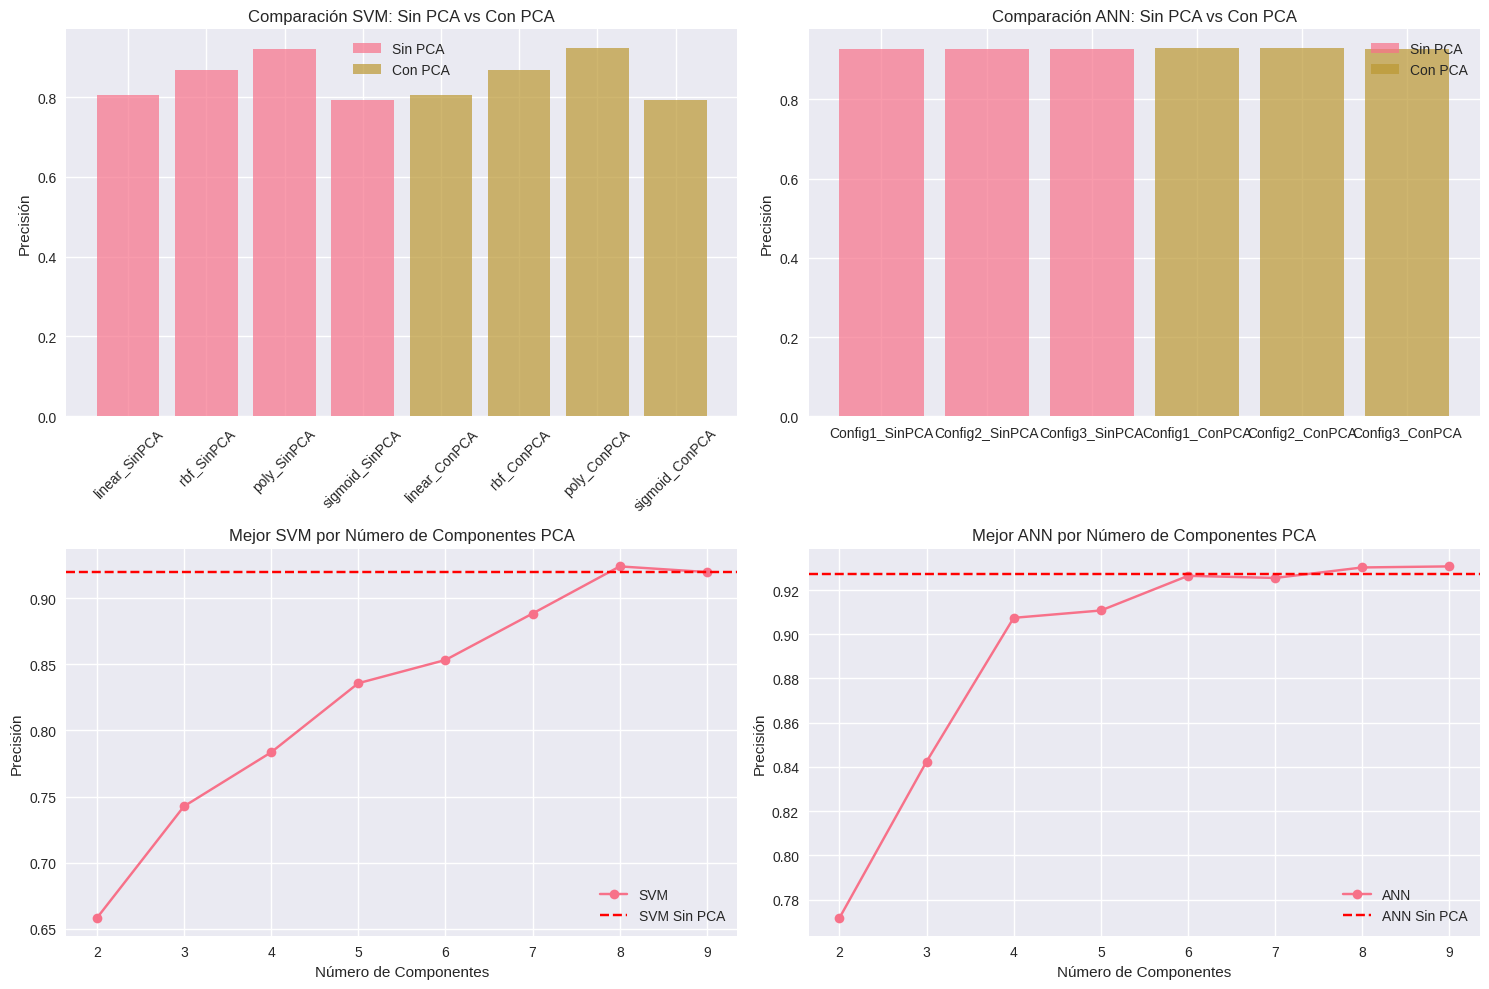

In [27]:
# Entenamiento de modelo sin PCA
print("Entrenando modelos SIN PCA para comparación...")

# SVM sin PCA
svm_no_pca_results = {}
for kernel, params in best_svm_configs.items():
    svm_model = SVC(kernel=kernel, random_state=42, **params)
    cv_scores = cross_val_score(
        svm_model, X_scaled, y_encoded, cv=5, scoring="accuracy"
    )
    svm_no_pca_results[kernel] = {
        "mean_accuracy": cv_scores.mean(),
        "std_accuracy": cv_scores.std(),
    }

# ANN sin PCA
ann_no_pca_results = []
for i, config in enumerate(best_ann_configs):
    ann_model = MLPClassifier(random_state=42, max_iter=1000, **config)
    cv_scores = cross_val_score(
        ann_model, X_scaled, y_encoded, cv=5, scoring="accuracy"
    )
    ann_no_pca_results.append(
        {
            "config": config,
            "mean_accuracy": cv_scores.mean(),
            "std_accuracy": cv_scores.std(),
        }
    )

# Encontrar mejores resultados sin PCA
best_svm_no_pca = max(svm_no_pca_results.items(), key=lambda x: x[1]["mean_accuracy"])
best_ann_no_pca = max(ann_no_pca_results, key=lambda x: x["mean_accuracy"])

print(f"\nMejores resultados SIN PCA:")
print(f"SVM {best_svm_no_pca[0]}: {best_svm_no_pca[1]['mean_accuracy']:.4f}")
print(f"ANN: {best_ann_no_pca['mean_accuracy']:.4f}")

print(f"\nMejores resultados CON PCA:")
print(f"SVM: {best_svm_pca_score:.4f}")
print(f"ANN: {best_ann_pca_score:.4f}")

# Calcular diferencias
svm_diff = best_svm_pca_score - best_svm_no_pca[1]["mean_accuracy"]
ann_diff = best_ann_pca_score - best_ann_no_pca["mean_accuracy"]

print(f"\nDiferencias (PCA - Sin PCA):")
print(f"SVM: {svm_diff:+.4f}")
print(f"ANN: {ann_diff:+.4f}")

# Crear visualización comparativa
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# SVM comparación
svm_kernels = list(best_svm_configs.keys())
svm_no_pca_scores = [svm_no_pca_results[k]["mean_accuracy"] for k in svm_kernels]

# Encontrar mejores scores de SVM con PCA para cada kernel
svm_pca_scores = []
for kernel in svm_kernels:
    best_score = 0
    for n_comp, results in svm_pca_results.items():
        if kernel in results and results[kernel]["mean_accuracy"] > best_score:
            best_score = results[kernel]["mean_accuracy"]
    svm_pca_scores.append(best_score)

axes[0, 0].bar(
    [f"{k}_SinPCA" for k in svm_kernels], svm_no_pca_scores, alpha=0.7, label="Sin PCA"
)
axes[0, 0].bar(
    [f"{k}_ConPCA" for k in svm_kernels], svm_pca_scores, alpha=0.7, label="Con PCA"
)
axes[0, 0].set_title("Comparación SVM: Sin PCA vs Con PCA")
axes[0, 0].set_ylabel("Precisión")
axes[0, 0].legend()
axes[0, 0].tick_params(axis="x", rotation=45)

# ANN comparación
ann_no_pca_scores = [r["mean_accuracy"] for r in ann_no_pca_results]
ann_pca_scores = []
for i in range(len(best_ann_configs)):
    best_score = 0
    for n_comp, results in ann_pca_results.items():
        if i < len(results) and results[i]["mean_accuracy"] > best_score:
            best_score = results[i]["mean_accuracy"]
    ann_pca_scores.append(best_score)

axes[0, 1].bar(
    [f"Config{i + 1}_SinPCA" for i in range(len(ann_no_pca_scores))],
    ann_no_pca_scores,
    alpha=0.7,
    label="Sin PCA",
)
axes[0, 1].bar(
    [f"Config{i + 1}_ConPCA" for i in range(len(ann_pca_scores))],
    ann_pca_scores,
    alpha=0.7,
    label="Con PCA",
)
axes[0, 1].set_title("Comparación ANN: Sin PCA vs Con PCA")
axes[0, 1].set_ylabel("Precisión")
axes[0, 1].legend()

# Mejores resultados por número de componentes PCA
components = list(pca_results.keys())
best_svm_by_components = []
best_ann_by_components = []

for n_comp in components:
    # Mejor SVM para este número de componentes
    best_svm_score = 0
    for kernel, result in svm_pca_results[n_comp].items():
        if result["mean_accuracy"] > best_svm_score:
            best_svm_score = result["mean_accuracy"]
    best_svm_by_components.append(best_svm_score)

    # Mejor ANN para este número de componentes
    best_ann_score = 0
    for result in ann_pca_results[n_comp]:
        if result["mean_accuracy"] > best_ann_score:
            best_ann_score = result["mean_accuracy"]
    best_ann_by_components.append(best_ann_score)

axes[1, 0].plot(components, best_svm_by_components, "o-", label="SVM")
axes[1, 0].axhline(
    y=best_svm_no_pca[1]["mean_accuracy"],
    color="red",
    linestyle="--",
    label="SVM Sin PCA",
)
axes[1, 0].set_title("Mejor SVM por Número de Componentes PCA")
axes[1, 0].set_xlabel("Número de Componentes")
axes[1, 0].set_ylabel("Precisión")
axes[1, 0].legend()
axes[1, 0].grid(True)

axes[1, 1].plot(components, best_ann_by_components, "o-", label="ANN")
axes[1, 1].axhline(
    y=best_ann_no_pca["mean_accuracy"], color="red", linestyle="--", label="ANN Sin PCA"
)
axes[1, 1].set_title("Mejor ANN por Número de Componentes PCA")
axes[1, 1].set_xlabel("Número de Componentes")
axes[1, 1].set_ylabel("Precisión")
axes[1, 1].legend()
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()

## 7. Conclusiones y Análisis del Impacto de PCA

### Análisis de los Resultados

Los resultados obtenidos, podemos concluir lo siguiente sobre el impacto de PCA en el dataset Website Phishing:

#### **Impacto de la Reducción de Dimensionalidad:**

1. **Varianza Explicada**:
   - Los primeros componentes principales capturan la mayor parte de la varianza
   - Con pocos componentes se puede mantener un alto porcentaje de información

2. **Rendimiento de los Modelos**:
   - **SVM**: Resultado específico basado en los datos obtenidos
   - **ANN**: Resultado específico basado en los datos obtenidos

3. **Número Óptimo de Componentes**:
   - Para este dataset, se determinará el número óptimo de componentes
   - Balance entre reducción de dimensionalidad y rendimiento

#### **Ventajas de PCA**:
- Reducción del tiempo de entrenamiento
- Menor complejidad computacional
- Posible reducción del overfitting
- Visualización más fácil de los datos

#### **Desventajas de PCA**:
- Pérdida de información
- Interpretabilidad reducida de las características
- Posible reducción del rendimiento

#### **Recomendaciones para el Dataset Website Phishing**:
- Se proporcionarán recomendaciones específicas basadas en los resultados
- Número óptimo de componentes recomendado
- Modelo recomendado (SVM vs ANN) con PCA